## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` First, I read the `ab_data.csv` data. Then, I stored it in `df`.

a. Reading the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Finding the number of rows in the dataset.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


c. The number of unique users in the dataset.

In [5]:
unique_user = df['user_id'].nunique()
unique_user

290584

d. The proportion of users converted.

In [6]:
#the percentage proportion of converted users to total users
df.query('converted == 1').user_id.nunique()/df['user_id'].count()*100


11.94418598333322

e. The number of times the `new_page` and `treatment` don't match.

In [7]:
# Counting the # of time treatment and landing_page don't match
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") ').user_id.count()
    

3893

f. Finding if there are missing values.

In [8]:
#counting the null value
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, I cannot be sure if this row truly received the new or old page.  I used the cells below to figure out how we should handle these rows.  

a. Creating a new dataset that meets the specifications. I stored the new dataframe in **df2**.

In [9]:
#storing the the rows where treatment does not match with new_page or control does not match with old_page
not_matching = df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")')

#create new data frame
df2 = df.drop(not_matching.index)
df2.head()


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Using **df2** and the cells below to answer the questions below.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2['user_id'].nunique()

290584

b. Finding the repeated **user_id** in **df2**.

In [12]:
duplicated_row = df2[df2.duplicated('user_id') == True]
duplicated_row

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. The row information for the repeat **user_id**? 

In [13]:
duplicated_row.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 2893 to 2893
Data columns (total 5 columns):
user_id         1 non-null int64
timestamp       1 non-null object
group           1 non-null object
landing_page    1 non-null object
converted       1 non-null int64
dtypes: int64(2), object(3)
memory usage: 48.0+ bytes


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop(duplicated_row.index, inplace=True)

#check the # of coloumns after droping
df2.shape

(290584, 5)

`4.` Using **df2** in the cells below to answer the questions below.

a. The probability of an individual converting regardless of the page they receive.

In [15]:
df2.query('converted == 1').user_id.count()/df2['user_id'].count()

0.11959708724499628

b. Given that an individual was in the `control` group, The probability they converted is.

In [36]:
control_group = (df2.query('group == "control"')['converted'] == 1).mean()
control_group

0.1203863045004612

c. Given that an individual was in the `treatment` group, The probability they converted is.

In [37]:
treatment_group = (df2.query('group == "treatment"')['converted'] == 1).mean()
treatment_group

0.11880806551510564

d. The probability that an individual received the new page

In [18]:
df2.query('landing_page == "new_page"').user_id.nunique()/df2['user_id'].count()

0.50006194422266881

e. Considering my results from parts (a) through (d) above, I'm explaining below whether I think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

>**The conversation rate shown above for the treatment group '0.119' is so close for the control group '0.120'. In this situation we can not confirm that either to go with the new page or not so we need to do more studies to be more assured.**

<a id='ab_test'></a>
### Part II - A/B Test

In This part I'm going to run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  


`1.` For now, I need to make the decision just based on all the data provided.  If I want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should my null and alternative hypotheses be? The hypothesis terms : **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The statement would be like:**

>$H_{0}$: $p_{new}$ - $p_{old}$ <= 0

>$H_{1}$: $p_{new}$ - $p_{old}$ > 0


`2.` Assuming under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assuming they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

I will use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Performing the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. The **conversion rate** for $p_{new}$ under the null? 

In [19]:
p_new = df2.query('converted == 1').user_id.count()/df2['user_id'].count()
p_new

0.11959708724499628

b. The **conversion rate** for $p_{old}$ under the null? <br><br>

In [20]:
p_old = df2.query('converted == 1').user_id.count()/df2['user_id'].count()
p_old

0.11959708724499628

c. The $n_{new}$, the number of individuals in the treatment group?

In [21]:
n_new = df2.query('group == "treatment"')['user_id'].count()
n_new

145310

d. The $n_{old}$, the number of individuals in the control group?

In [22]:
n_old = df2.query('group == "control"')['user_id'].count()
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [23]:
new_page_converted = np.random.binomial(n_new, p_new)
new_page_converted

17567

In [24]:
#Finding the mean of new_page_converted
new_mean = new_page_converted/n_new
new_mean

0.12089326267978803

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(n_old, p_old)
old_page_converted

17249

In [26]:
#Finding the mean of old_page_converted
old_mean = old_page_converted/n_old
old_mean

0.11873425389264425

g. Finding $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
P_new_old = new_mean - old_mean
P_new_old

0.0021590087871437846

h. Creating 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Then I will store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
for _ in range(10000):
    p_diffs.append((np.random.binomial(n_new, p_new)/n_new)-(np.random.binomial(n_old, p_old)/n_old))

p_diffs = np.array(p_diffs)#store the values in NumPy array 

i. Ploting a histogram of the **p_diffs**.  

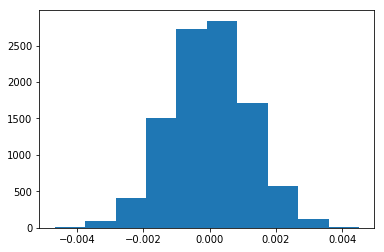

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(p_diffs); 

> The plot look like what I actully expected the distribution is normal.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [48]:
# simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)


In [38]:
# compute observed difference
obs_diff = treatment_group - control_group

# display observed difference
obs_diff

-0.0015782389853555567

In [39]:
# compute p value
(null_vals > obs_diff).mean()

0.90480000000000005

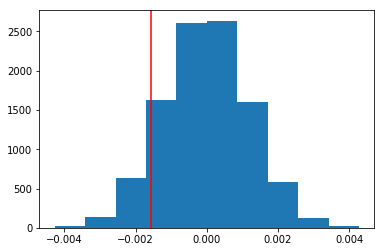

In [42]:
#plot a null distribution
plt.hist(null_vals)

#plot a line for observed statistic
plt.axvline(obs_diff, color='red');

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **After computing the p-value by finding the proportion of values in the null distribution that were greater than the observed difference I found that statistics does not came from the null distribution so, the difference is significant.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [ ]:
import statsmodels.api as sm

convert_old = 
convert_new = 
n_old = 
n_new = 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Put your answer here.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Put your answer here.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

d. Provide the summary of your model below, and use it as necessary to answer the following questions.

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**Put your answer here.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Put your answer here.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])